# I] Import + user-defined variables

In [1]:
import pandas, numpy, math, seaborn
import scipy, scipy.stats
import matplotlib, matplotlib.pyplot as plt
# this is a trick to make figures look nicer
matplotlib.rcParams.update({'font.size':20, 'font.family':'FreeSans', 'xtick.labelsize':20, 'ytick.labelsize':10, 'figure.figsize':(12, 8)})

In [2]:
from matplotlib_venn import venn2

## functions & options


In [3]:
input_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7//0 in_silico/Python/1)data_input/'

In [4]:
output_file_directory = '/Users/kja11/OneDrive - Háskóli Íslands/PhD ATG7/0 in_silico/Python/3)output/'

# II] Dataframe downlaod

In [5]:
%%time
# DL data gene expression for Normal Tissue and Primary Tumors
path = output_file_directory + "/GABARAP/dataframes_for_input/"
ensembl_normal_GABARAP_proteinGE = pandas.read_csv(path+"ensembl_normal_GABARAP_proteinGE.tsv", sep = "\t")
ensembl_primary_GABARAP_proteinGE = pandas.read_csv(path+"ensembl_primary_GABARAP_proteinGE.tsv", sep = "\t")

print(ensembl_normal_GABARAP_proteinGE.shape)
print(ensembl_primary_GABARAP_proteinGE.shape)
ensembl_normal_GABARAP_proteinGE.head(2)

(7429, 19387)
(9185, 19387)
Wall time: 3min 25s


,Sample_Type,Primary_Site,GABARAP,GABARAP_1,GABARAP_2,ENSG00000198888,ENSG00000198763,ENSG00000198804,ENSG00000198712,ENSG00000228253,...,ENSG00000160678,ENSG00000160679,ENSG00000143553,ENSG00000214193,ENSG00000196182,ENSG00000181817,ENSG00000116885,ENSG00000116898,ENSG00000119535,ENSG00000142694
0,Normal Tissue,Blood,11.27,7.823,9.316,11.4278,11.9220,12.4100,13.1565,12.9439,...,2.1313,5.8726,4.8314,1.0433,6.1056,6.3116,1.4494,5.0527,11.9031,1.8484
1,Normal Tissue,Blood,11.24,6.587,9.797,11.1244,10.6001,11.5536,12.0039,11.6778,...,-1.8314,5.2601,4.2442,0.6050,6.9870,6.0466,-0.5125,4.4894,12.6822,4.4700


In [6]:
%%time
#download the protein coding list. will be useful with correlation results.
path = input_file_directory + "protein_coding_list.txt"
protein_coding_list= pandas.read_csv(path, sep = "\t")
print(protein_coding_list.shape)
protein_coding_list.head()

(22796, 4)
Wall time: 40.9 ms


,ensembl_gene_id,hgnc_symbol,entrezgene_id,transcript_biotype
1,ENSG00000198888,MT-ND1,4535.0,protein_coding
2,ENSG00000198763,MT-ND2,4536.0,protein_coding
3,ENSG00000198804,MT-CO1,4512.0,protein_coding
4,ENSG00000198712,MT-CO2,4513.0,protein_coding
5,ENSG00000228253,MT-ATP8,4509.0,protein_coding


# III] Expression correlation between GABARAP and all protein coding 

In [16]:
%%time
# pearson Correlation, all genes WITHOUT cutoff
all_tissue_used = [[ensembl_normal_GABARAP_proteinGE,'Normal_Tissues'], [ensembl_primary_GABARAP_proteinGE,'Primary_Tumors']]

isoforms = ['GABARAP_1', 'GABARAP_2']

all_positiv_corr_pearson = []
all_negativ_corr_pearson = []

for tissue in all_tissue_used:
  print(tissue[1], tissue[0].shape)

  #create a new row with max() for each gene and transpose
  tissue[0].loc['max()'] = tissue[0].max()
  tissue[0] = tissue[0].T

  #select all row where max() > 2.3 (= 5 tpm)
  nb_before = tissue[0]['max()'].count()
  tissue[0] = tissue[0].drop(tissue[0].index[0:2])
  tissue[0] = tissue[0][tissue[0]['max()'] > 2.3]
  nb_after = tissue[0]['max()'].count()
  print("number of genes removed:", nb_before-nb_after)
  print('the minimum of TPM is', tissue[0]['max()'].min())
  
  #delete the column max() and tranpose back
  tissue[0] =  tissue[0].drop('max()', axis = 1) 
  tissue[0] = tissue[0].T
  print('nombre genes after removing < 4tpm', tissue[0].shape)

  for isoform in isoforms:

    genepos = []
    geneneg = []
    rvaluepos = []
    rvalueneg = []
    pvaluepos = []
    pvalueneg = []

    print(isoform)
    x = tissue[0][isoform].to_list()
    genes = tissue[0].columns[3:]

    for gene in genes:
      y = tissue[0][gene].to_list()
      r_value, p_value = scipy.stats.pearsonr(x, y)

      if r_value > 0:
        genepos.append(gene)
        rvaluepos.append(r_value)
        pvaluepos.append(p_value)
        
      elif r_value < 0:
        geneneg.append(gene)
        rvalueneg.append(r_value)
        pvalueneg.append(p_value)

    #create a dictionnary
    d = dict(ensembl_gene_id= genepos, r_value=rvaluepos,  p_value=pvaluepos)
    d2 = dict(ensembl_gene_id= geneneg, r_value=rvalueneg,  p_value=pvalueneg)

    #Convert to dataframe
    df_positiv_corr = pandas.DataFrame.from_dict(d, orient='index')
    df_negativ_corr = pandas.DataFrame.from_dict(data=d2, orient='index')

    #Transpose to have a better table
    df_positiv_corr = df_positiv_corr.transpose()
    df_negativ_corr = df_negativ_corr.transpose()

    #name
    positiv_corr = 'pos_pearson_corr_'+tissue[1]+'_'+isoform
    negativ_corr = 'neg_pearson_corr_'+tissue[1]+'_'+isoform

    print(positiv_corr, df_positiv_corr.shape)
    print(negativ_corr, df_negativ_corr.shape)

    #scending orde, save to excel
    df_positiv_corr['info'] = tissue[1]+'_'+isoform
    df_positiv_corr = protein_coding_list.merge(df_positiv_corr)
    df_positiv_corr = df_positiv_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_positiv_corr = df_positiv_corr.sort_values(['r_value'], ascending = False)
    
    #save positive
    path = 'GABARAP/table_correlation_enrichr/all_tissue/corr_all/'
    df_positiv_corr.to_excel(output_file_directory+path+positiv_corr+'.xlsx', index=False)
    
    df_negativ_corr['info'] = tissue[1]+'_'+isoform
    df_negativ_corr = protein_coding_list.merge(df_negativ_corr)
    df_negativ_corr = df_negativ_corr.drop(['entrezgene_id', 'transcript_biotype'], axis = 1)
    df_negativ_corr = df_negativ_corr.sort_values(['r_value'], ascending = False)

    #save negative
    df_negativ_corr.to_excel(output_file_directory+path+negativ_corr+'.xlsx', index=False)
    
    all_positiv_corr_pearson.append(df_positiv_corr)
    all_negativ_corr_pearson.append(df_negativ_corr)
  print()

Normal_Tissues (7430, 19387)
number of genes removed: 943
the minimum of TPM is 2.3019
nombre genes after removing < 4tpm (7429, 18443)
GABARAP_1
pos_pearson_corr_Normal_Tissues_GABARAP_1 (17498, 3)
neg_pearson_corr_Normal_Tissues_GABARAP_1 (942, 3)
GABARAP_2
pos_pearson_corr_Normal_Tissues_GABARAP_2 (17597, 3)
neg_pearson_corr_Normal_Tissues_GABARAP_2 (843, 3)

Primary_Tumors (9185, 19387)
number of genes removed: 841
the minimum of TPM is 2.3048
nombre genes after removing < 4tpm (9185, 18546)
GABARAP_1
pos_pearson_corr_Primary_Tumors_GABARAP_1 (11861, 3)
neg_pearson_corr_Primary_Tumors_GABARAP_1 (6682, 3)
GABARAP_2
pos_pearson_corr_Primary_Tumors_GABARAP_2 (14348, 3)
neg_pearson_corr_Primary_Tumors_GABARAP_2 (4195, 3)

Wall time: 4min 11s


## 1) Distribution of all rvalue to select cutoff

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


shape positiv (946, 5)
shape negativ (17625, 5)
shape after merge (18571, 5)
shape positiv (845, 5)
shape negativ (17726, 5)
shape after merge (18571, 5)
shape positiv (6741, 5)
shape negativ (11933, 5)
shape after merge (18674, 5)
shape positiv (4237, 5)
shape negativ (14437, 5)
shape after merge (18674, 5)
shape normal (18571, 5)
shape primary (18571, 5)
shape after merge (37142, 5)
shape normal (18674, 5)
shape primary (18674, 5)
shape after merge (37348, 5)


findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


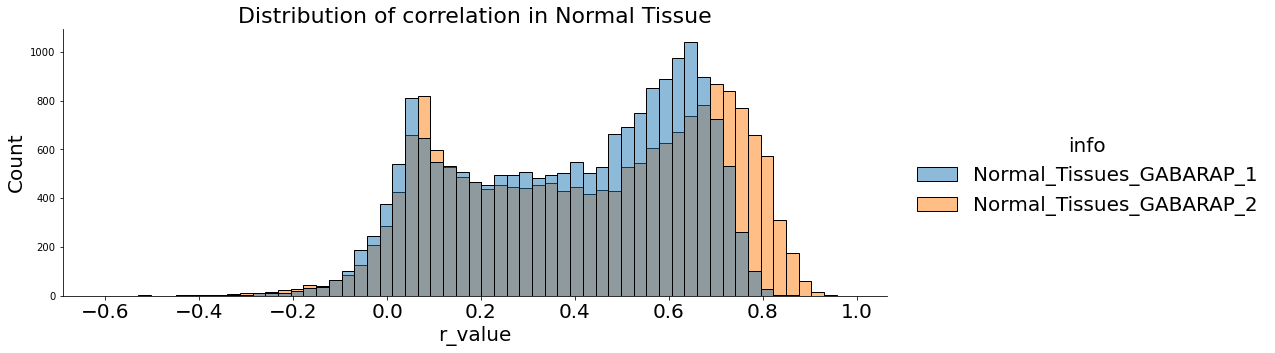

<Figure size 864x576 with 0 Axes>

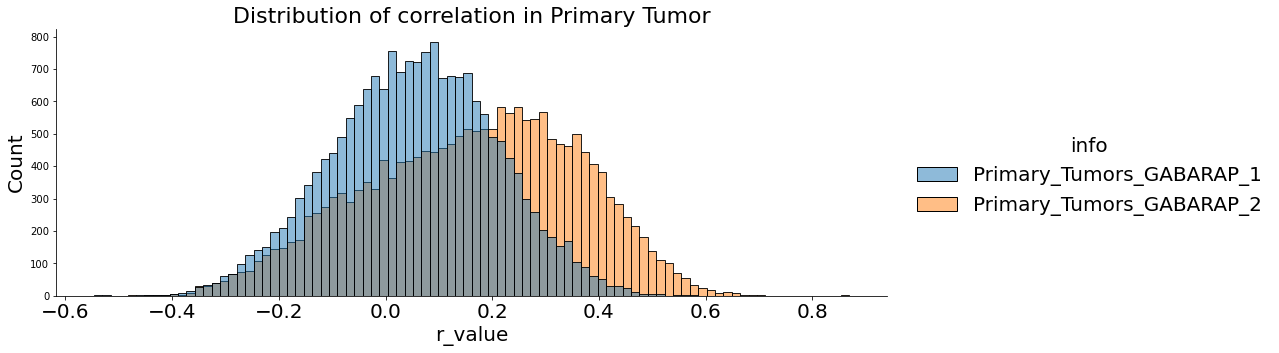


Wall time: 1.91 s


<Figure size 864x576 with 0 Axes>

In [17]:
%%time
#Merge Negative and Positive data
data =  [
         [all_negativ_corr_pearson[0], all_positiv_corr_pearson[0], 'Normal Tissue, GABARAP(1)'], 
         [all_negativ_corr_pearson[1], all_positiv_corr_pearson[1], 'Normal Tissue, GABARAP(2)'],
         [all_negativ_corr_pearson[2], all_positiv_corr_pearson[2], 'Primary Tumor, GABARAP(1)'], 
         [all_negativ_corr_pearson[3], all_positiv_corr_pearson[3], 'Primary Tumor, GABARAP(2)']
         ]

all_corr_negpos_merged = []
for dfs in data:
  print('shape positiv', dfs[0].shape)
  print('shape negativ', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_negpos_merged.append(df_merged)

#Merge GABARAP(1) and GABARAP(2)
data = [
        [all_corr_negpos_merged[0], all_corr_negpos_merged[1], 'Normal Tissue'],
        [all_corr_negpos_merged[2], all_corr_negpos_merged[3], 'Primary Tumor']
        ]

all_corr_isoforms_merged = []
for dfs in data:
  print('shape normal', dfs[0].shape)
  print('shape primary', dfs[1].shape)

  df_merged = pandas.concat([dfs[0], dfs[1]], axis=0)
  df_merged = df_merged.reset_index(drop = True)
  print('shape after merge', df_merged.shape)
  all_corr_isoforms_merged.append(df_merged)

#Distribution of correlation
data = [
        [all_corr_isoforms_merged[0], 'Normal Tissue'],
        [all_corr_isoforms_merged[1], 'Primary Tumor']
        ]

for dfs in data:
  seaborn.displot(dfs[0], x="r_value", hue='info', aspect = 2.6)
  label_title = 'Distribution of correlation in ' + dfs[1]
  plt.title(label_title, fontsize = 22)
  plt.show()
  plt.clf()
  print()

## 2) Selection of the 1% the most correlated genes.

In [18]:
all_corr_negpos_extremities = []

for df in all_corr_negpos_merged:
  df = df.sort_values(['r_value'], ascending = False)
  df = df.reset_index(drop = True)
  
  lenght = len(df)
  only_1_perc = int(lenght*0.010)
  just_head = only_1_perc
  just_tail = lenght - only_1_perc

  df_head = df.iloc[0:just_head,:]
  df_tail = df.iloc[just_tail:,:]
  df_extremeties = pandas.concat([df_head, df_tail], axis=0)

  inform = df['info'][1]
  extremities_name = 'corr_1%extremities'+ '_pearson_' +inform
#   df_extremeties.to_excel(extremities_name+'.xlsx', index=False)

  all_corr_negpos_extremities.append(df_extremeties)

# IV] Venn diagrams

In [23]:
all_corr_negpos_extremities[0]

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
0,ENSG00000170296,GABARAP,0.874045,0,Normal_Tissues_GABARAP_1
1,ENSG00000219200,RNASEK,0.849602,0,Normal_Tissues_GABARAP_1
2,ENSG00000163041,H3-3A,0.830165,0,Normal_Tissues_GABARAP_1
3,ENSG00000022277,RTF2,0.829565,0,Normal_Tissues_GABARAP_1
4,ENSG00000130724,CHMP2A,0.817956,0,Normal_Tissues_GABARAP_1
...,...,...,...,...,...
18566,ENSG00000176742,OR51V1,-0.432504,0,Normal_Tissues_GABARAP_1
18567,ENSG00000183389,OR56A4,-0.442527,0,Normal_Tissues_GABARAP_1
18568,ENSG00000254834,OR5M10,-0.446004,0,Normal_Tissues_GABARAP_1
18569,ENSG00000121377,TAS2R7,-0.465302,0,Normal_Tissues_GABARAP_1


In [24]:
#separate pos and neg correlation
all_corr_positiv_extremities = []
all_corr_negativ_extremities = []

for df in all_corr_negpos_extremities:
    data_pos = df[df['r_value']>0]
    data_neg = df[df['r_value']<0]
    all_corr_positiv_extremities.append(data_pos)
    all_corr_negativ_extremities.append(data_neg)
len(all_corr_positiv_extremities)
all_corr_negativ_extremities[0].head()

,ensembl_gene_id,hgnc_symbol,r_value,p_value,info
18386,ENSG00000170579,DLGAP1,-0.105765,6.23627e-20,Normal_Tissues_GABARAP_1
18387,ENSG00000204536,CCHCR1,-0.106033,5.02765e-20,Normal_Tissues_GABARAP_1
18388,ENSG00000257767,NaN,-0.106782,2.74238e-20,Normal_Tissues_GABARAP_1
18389,ENSG00000183631,PRR32,-0.107463,1.57524e-20,Normal_Tissues_GABARAP_1
18390,ENSG00000253506,NACA2,-0.107622,1.38371e-20,Normal_Tissues_GABARAP_1


## 1) Venn diagrams of correlation of all the genes

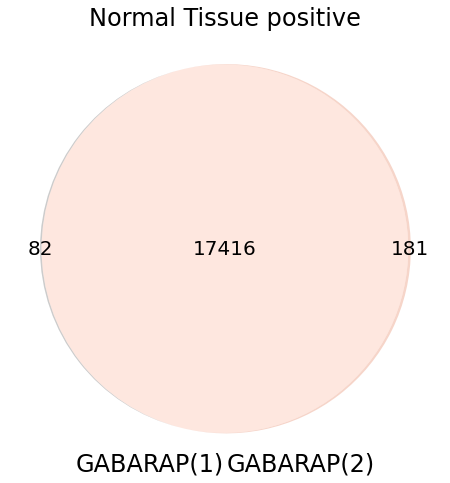

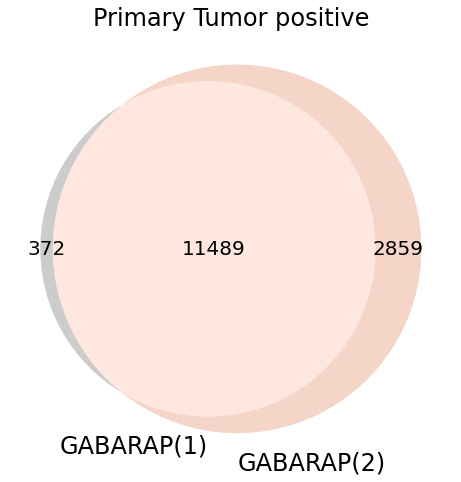

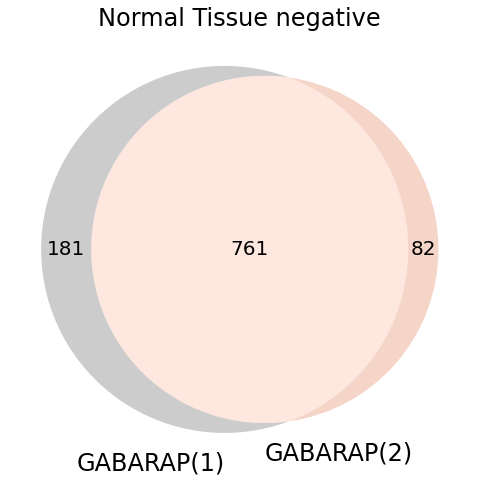

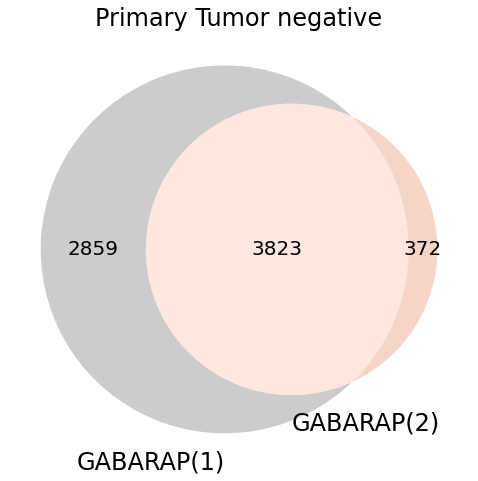

<Figure size 864x576 with 0 Axes>

In [27]:
#VENN DIAGRAMS FOR 100% of the genes

data_pos =  [
         [all_positiv_corr_pearson[0], all_positiv_corr_pearson[1], 'Normal Tissue', 'positive'], 
         [all_positiv_corr_pearson[2], all_positiv_corr_pearson[3], 'Primary Tumor', 'positive']
         ]

data_neg =  [
         [all_negativ_corr_pearson[0], all_negativ_corr_pearson[1], 'Normal Tissue', 'negative'], 
         [all_negativ_corr_pearson[2], all_negativ_corr_pearson[3], 'Primary Tumor', 'negative']
         ]

data = data_pos + data_neg

list_only1 = []
list_only2 = []

for dfs in data:
  set1 = set(dfs[0]['ensembl_gene_id'])
  set2 = set(dfs[1]['ensembl_gene_id'])
  subset = (set1, set2)

  #just to save some results in list
  with_only1 = set2.symmetric_difference(set1) & set1
  list_only1.append(with_only1)

  with_only2 = set2.symmetric_difference(set1) & set2
  list_only2.append(with_only2)

  #Venn Diagram
  venn2(subset, set_labels=('GABARAP(1)', 'GABARAP(2)'), set_colors=('grey', 'darksalmon'))
  label_title = dfs[2] + ' ' + dfs[3]
  plt.title(label_title)
  plt.show()
  plt.clf()
  print()



## 2) Venn diagrams of the 1% the most correlated genes with the two isoforms for each tissue 

findfont: Font family ['FreeSans'] not found. Falling back to DejaVu Sans.


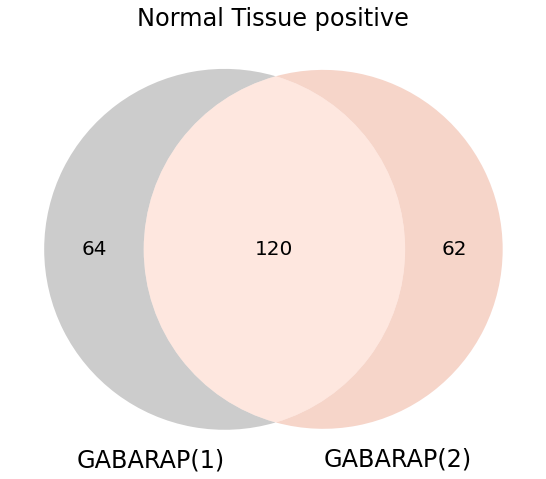

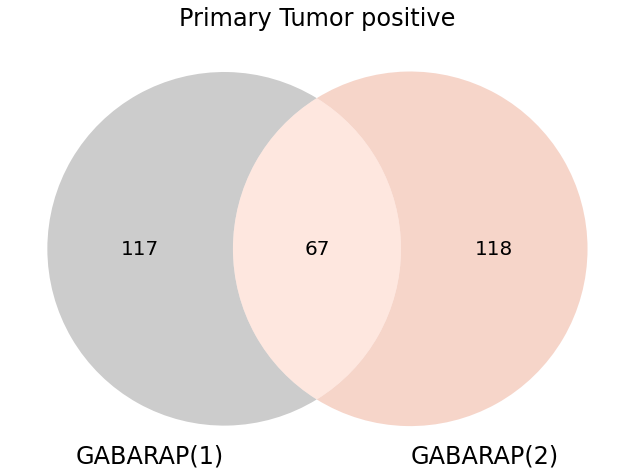

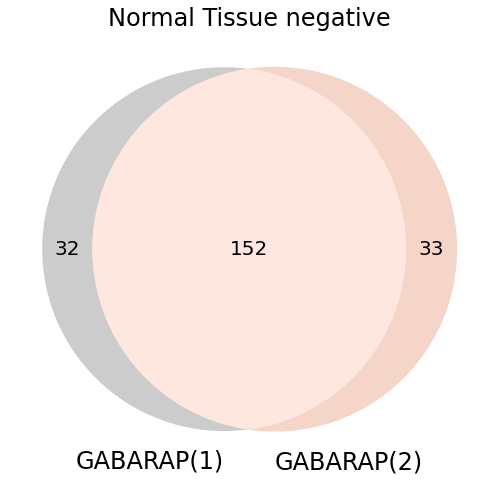

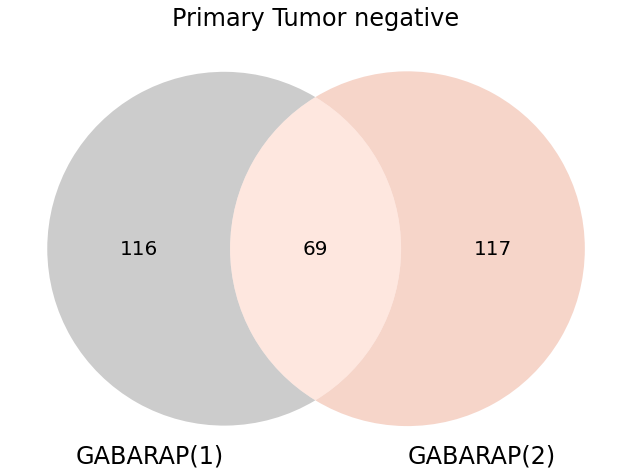

<Figure size 864x576 with 0 Axes>

In [26]:
#VENN DIAGRAMS GABARAP(1)vs GABARAP(2) FOR the 1% of the genes the most correlated
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[1], 'Normal Tissue', 'positive'], 
         [all_corr_positiv_extremities[2], all_corr_positiv_extremities[3], 'Primary Tumor', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[1], 'Normal Tissue', 'negative'], 
         [all_corr_negativ_extremities[2], all_corr_negativ_extremities[3], 'Primary Tumor', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_only1 = list(set2.symmetric_difference(set1) & set1)
    with_only2 = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_GABARAP_1 = with_only1, Only_GABARAP_2 = with_only2, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_pearson_isos'+dfs[2]+dfs[3]

    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'GABARAP/table_correlation_enrichr/all_tissue/corr_extremities/'
    df_only_and_intersection.to_excel(output_file_directory+path+name_file+'.xlsx', index=False)

    #Venn Diagram
    venn2(subset, set_labels=('GABARAP(1)', 'GABARAP(2)'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    plt.show()
    plt.clf()
    print()



In [28]:
print((len(list_only2)), '= norm_pos_iso2, norm_neg_iso2, prim_pos_iso2, prim_neg_iso2, ')

4 = norm_pos_iso2, norm_neg_iso2, prim_pos_iso2, prim_neg_iso2, 


## 3) Venn diagrams of the 1% the most correlated genes for each isoform in normal and primary tissues

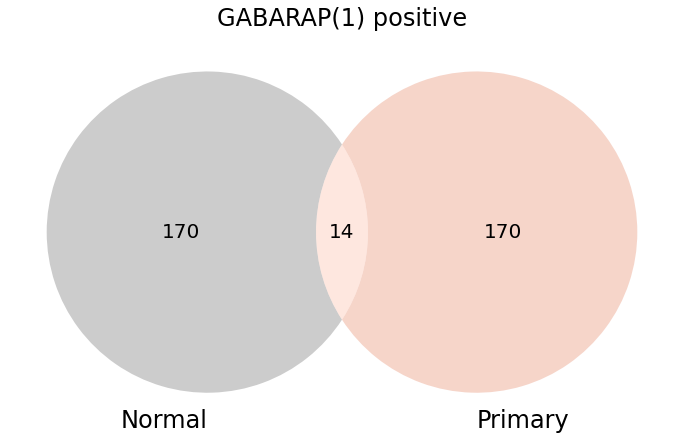

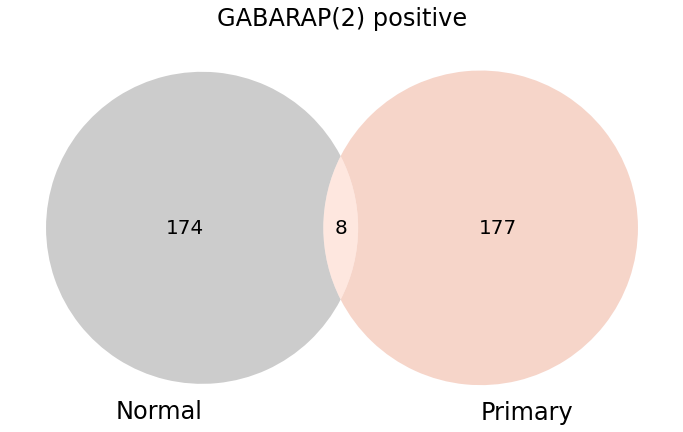

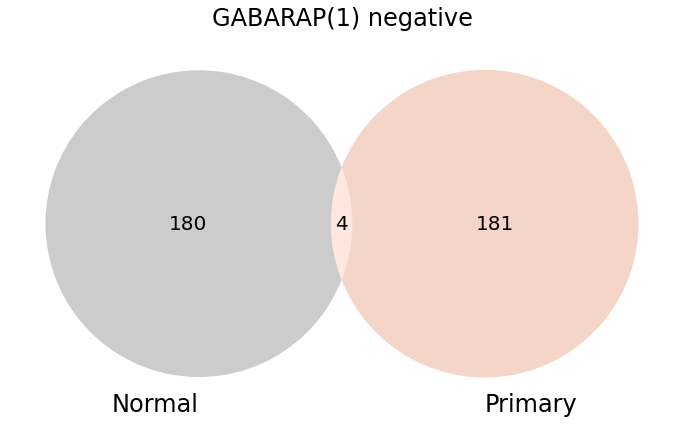

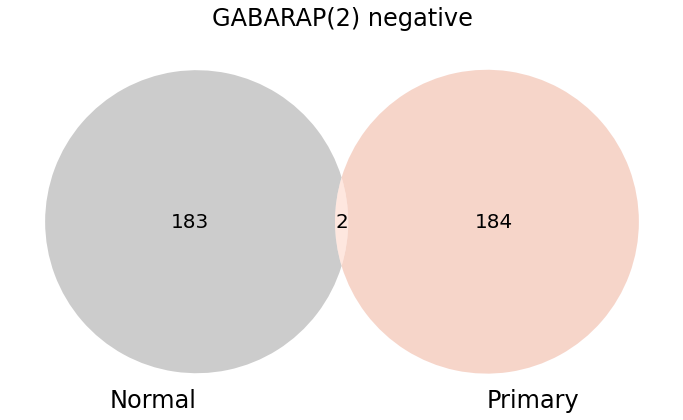

<Figure size 864x576 with 0 Axes>

In [29]:
#VENN DIAGRAMS FOR NORM vs PRIM for the 1% of the genes the most correlated
data_pos =  [
         [all_corr_positiv_extremities[0], all_corr_positiv_extremities[2], 'GABARAP(1)', 'positive'], 
         [all_corr_positiv_extremities[1], all_corr_positiv_extremities[3], 'GABARAP(2)', 'positive']
         ]

data_neg =  [
         [all_corr_negativ_extremities[0], all_corr_negativ_extremities[2], 'GABARAP(1)', 'negative'], 
         [all_corr_negativ_extremities[1], all_corr_negativ_extremities[3], 'GABARAP(2)', 'negative']
         ]

data = data_pos + data_neg

for dfs in data:
    set1 = set(dfs[0]['hgnc_symbol'])
    set2 = set(dfs[1]['hgnc_symbol'])
    subset = (set1, set2)

    #save results in list
    with_normal = list(set2.symmetric_difference(set1) & set1)
    with_primary = list(set2.symmetric_difference(set1) & set2)
    intersection = set1.intersection(set2)

    #create a dictionnary
    d = dict(Only_normal = with_normal, Only_primary = with_primary, Intersection= intersection)

    #Convert to dataframe
    df_only_and_intersection = pandas.DataFrame.from_dict(d, orient='index')
    name_file = 'only_and_intersection_isos_'+dfs[2]+'_'+dfs[3]
       
    #Transpose to have a better table and save
    df_only_and_intersection = df_only_and_intersection.transpose()
    df_only_and_intersection['info'] = dfs[2]+dfs[3]
    
    path = 'GABARAP/table_correlation_enrichr/all_tissue/corr_extremities/'
    df_only_and_intersection.to_excel(output_file_directory+path+name_file+'.xlsx', index=False)
    
    #Venn Diagram
    venn2(subset, set_labels=('Normal', 'Primary'), set_colors=('grey', 'darksalmon'))
    label_title = dfs[2] + ' ' + dfs[3]
    plt.title(label_title)
    plt.show()
    plt.clf()
    print()